In [1]:
import torch
import numpy as np
import warnings
import matplotlib.pyplot as plt
import os
warnings.filterwarnings('ignore', 'FutureWarning')
warnings.filterwarnings('ignore', 'TqdmExperimentalWarning')
warnings.filterwarnings('ignore', 'UserWarning')
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from collections import Counter
from tqdm.autonotebook import tqdm
from torchmetrics import Accuracy

/tmp/ipykernel_10332/33146339.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import pandas as pd
import seaborn as sns

In [3]:
nn_0 = pd.read_csv('task1/nn_0.csv')
nn_0.name = 'nn_0'
nn_0a = pd.read_csv('task1/nn_0a.csv')
nn_0a.name='nn_0a'
nn_1 = pd.read_csv('task1/nn_1.csv')
nn_1.name = 'nn_1'

<Axes: >

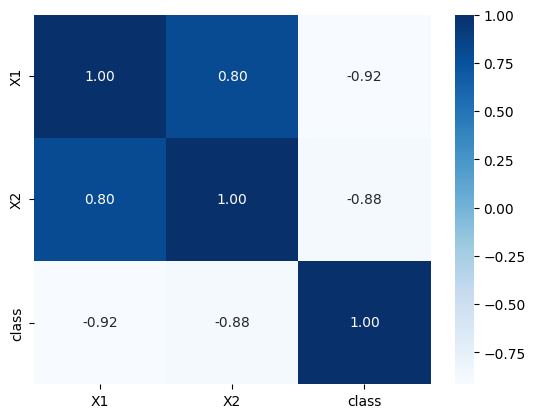

In [4]:
sns.heatmap(nn_0.corr(), annot=True, cmap='Blues', fmt='.2f')

<Axes: >

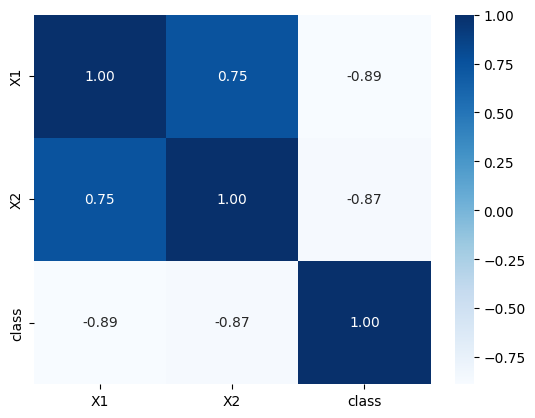

In [5]:
sns.heatmap(nn_0a.corr(), annot=True, cmap='Blues', fmt='.2f')

<Axes: >

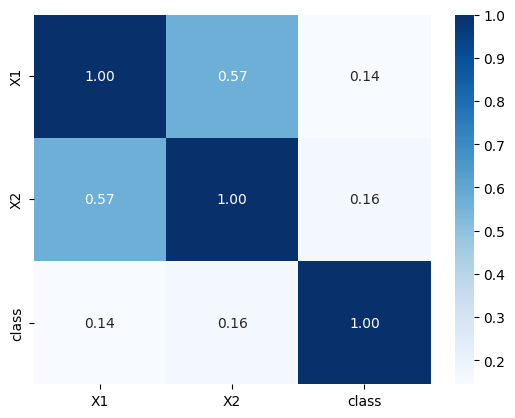

In [6]:
sns.heatmap(nn_1.corr(), annot=True, cmap='Blues', fmt='.2f')

<Axes: xlabel='X1', ylabel='X2'>

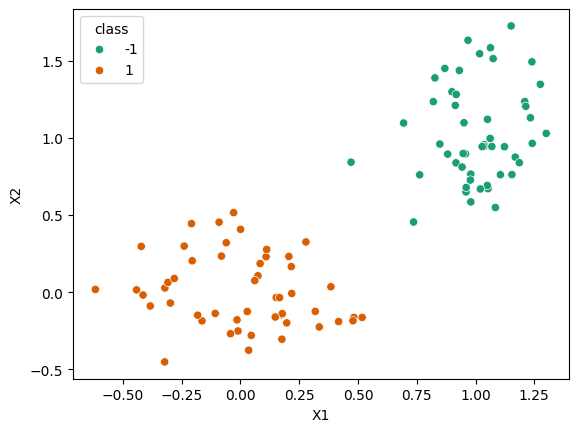

In [7]:
sns.scatterplot(x='X1', y='X2', data=nn_0, palette='Dark2', hue='class')

<Axes: xlabel='X1', ylabel='X2'>

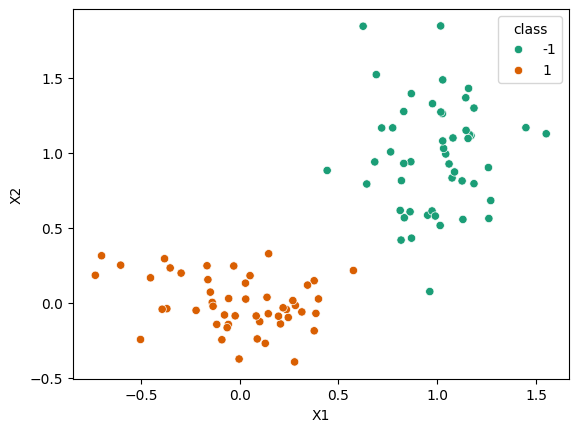

In [8]:
sns.scatterplot(x='X1', y='X2', data=nn_0a, palette='Dark2', hue='class')

<Axes: xlabel='X1', ylabel='X2'>

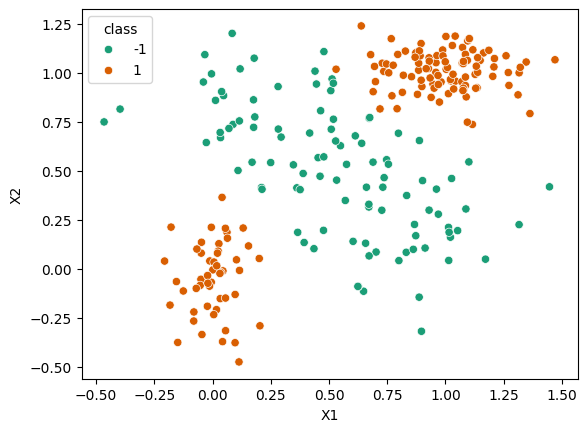

In [9]:
sns.scatterplot(x='X1', y='X2', data=nn_1, palette='Dark2', hue='class')

<Axes: xlabel='class', ylabel='count'>

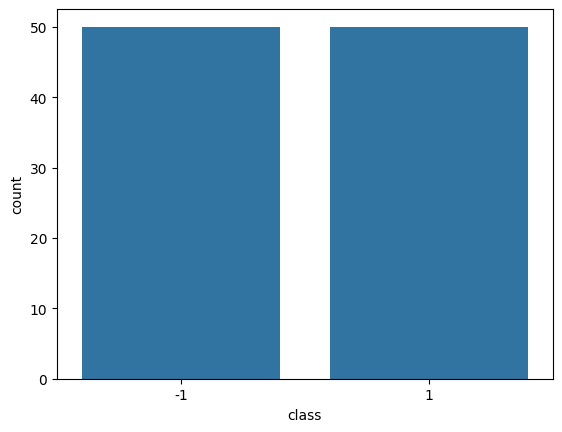

In [10]:
sns.countplot(data=nn_0, x='class')

<Axes: xlabel='class', ylabel='count'>

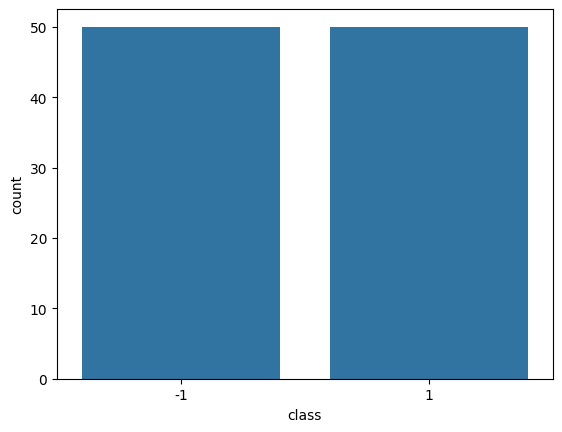

In [11]:
sns.countplot(data=nn_0a, x='class')

<Axes: xlabel='class', ylabel='count'>

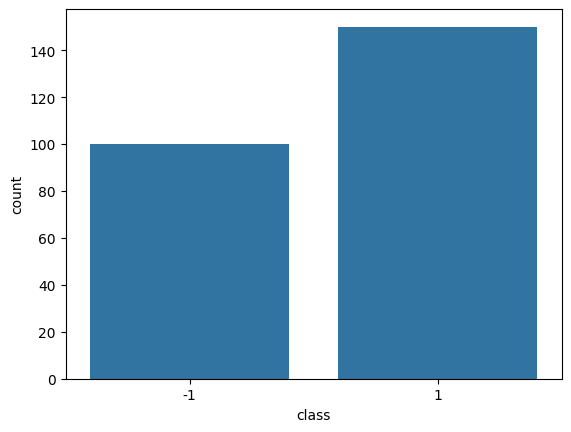

In [12]:
sns.countplot(data=nn_1, x='class')

In [13]:
BATCH = 16

In [14]:
X_0 = nn_1.drop('class', axis=1)
y_0 = nn_1['class'].map({-1: 0, 1: 1})
X_test = nn_0.drop('class', axis=1)
y_test = nn_0['class'].map({-1: 0, 1: 1})

In [15]:
train_X = torch.from_numpy(X_0.to_numpy()).to(torch.float32)
train_y = torch.from_numpy(y_0.to_numpy()).to(torch.float32)

In [16]:
test_X = torch.from_numpy(X_test.to_numpy()).to(torch.float32)
test_y = torch.from_numpy(y_test.to_numpy()).to(torch.float32)

In [17]:
train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)

In [18]:
train_loader = DataLoader(train_dataset, batch_size=BATCH)
test_loader = DataLoader(test_dataset, batch_size=BATCH)

In [19]:
class Neural_Network(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.lin_linear = nn.Linear(in_features, in_features * 10)
        self.lin_linear1 = nn.Linear(in_features * 10, out_features)
        self.f = F.relu
    
    def forward(self, x):
        x = self.lin_linear(x)
        x = self.f(x)
        x = self.lin_linear1(x)
        return x
        

In [20]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
model = Neural_Network(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.042)
model = model.to(DEVICE)
accuracy = Accuracy(task="binary").to(DEVICE)
losses_train = []
total_loss = []
acc_val = []
MAX_EPOCHS = 100

In [22]:
for epoch in tqdm(range(MAX_EPOCHS)):
    for iteration, (X_batch, y_batch) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()

        outputs = model(X_batch.to(DEVICE))
        outputs = outputs.view(-1)
        loss = loss_function(outputs, y_batch.to(DEVICE))
        loss.backward()

        losses_train.append(loss.detach().cpu().numpy().item())
        optimizer.step()
    total_loss.append(np.mean(losses_train))

for iteration, (X_batch, y_batch) in enumerate(test_loader):
    model.eval()

    with torch.no_grad():
        outputs = model(X_batch.to(DEVICE))
        outputs = outputs.view(-1)
        loss = loss_function(outputs, y_batch.to(DEVICE))
        proba = torch.sigmoid(outputs)
        batch_acc = accuracy(proba, y_batch.to(torch.int32).to(DEVICE))
        acc_val.append(batch_acc.detach().cpu().numpy().item())
acc = np.mean(acc_val)
print(f'Accuracy = {acc:.2f}')

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy = 0.56


/home/serg/anaconda3/envs/torch/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


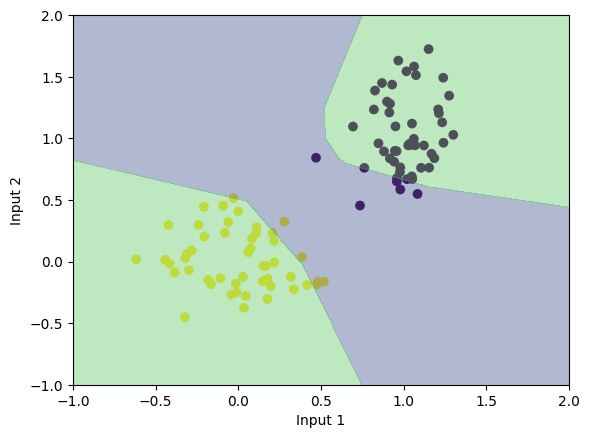

In [23]:
plt.figure()
plt.scatter(test_X[:, 0], test_X[:, 1], c=test_y.squeeze())
plt.xlabel('Input 1')
plt.ylabel('Input 2')
model=model.to('cpu')
xx, yy = torch.meshgrid(torch.linspace(-1,2, 1000), torch.linspace(-1, 2, 1000))
xy = torch.stack([xx, yy], dim=-1).reshape(-1, 2)
with torch.no_grad():
    pred = model(xy).squeeze().numpy()
plt.contourf(xx.numpy(), yy.numpy(), pred.reshape(1000, 1000), levels=1, alpha=0.4)


In [24]:
import torchvision
trans = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
mnist = torchvision.datasets.MNIST(root='./data', download=True, transform=trans)

In [25]:
mnist_dataloader = DataLoader(mnist, shuffle=True, batch_size=16, num_workers=1, drop_last=True)

In [26]:
class Neural_Numbers(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(28 * 28, 100)
        self.linear2 = nn.Linear(100, 10)
        self.act = F.relu

    def forward(self, x):
        out = self.flatten(x)
        out = self.linear1(out)
        out = self.act(out)
        out = self.linear2(out)
        return out

In [27]:
loss_fn = nn.CrossEntropyLoss()
model = Neural_Numbers()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
def accuracy(pred, label):
    answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
    return answer.mean()

In [ ]:
epochs = 10
for epoch in range(epochs):
    loss_val = 0
    acc_val = 0
    for img, label in (pbar := tqdm(mnist_dataloader)):
        optimizer.zero_grad()

        label = F.one_hot(label, 10).float()
        pred = model(img)

        loss = loss_fn(pred, label)
        loss.backward()
        loss_item = loss.item()
        loss_val += loss_item
        
        optimizer.step()
        acc_current = accuracy(pred, label)
        acc_val += acc_current
        pbar.set_description(f'loss: {loss_item:4e}\taccuracy: {acc_current:.3f}')
        
    print(loss_val / len(mnist_dataloader))
    print(acc_val / len(mnist_dataloader))

  0%|          | 0/3750 [00:00<?, ?it/s]

/tmp/ipykernel_10332/2946782038.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)


In [ ]:
import cv2
img = cv2.imread('test.png', cv2.IMREAD_GRAYSCALE)
img = np.expand_dims(img, axis=0)
img = np.expand_dims(img, axis=0)
img = img.astype(np.float32)/255.0

t_img = torch.from_numpy(img)
pred = model(t_img)
F.softmax(pred).detach().numpy().argmax()